In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('Table_data_total.csv',sep=';',header=0)

### Get average day and avg drosophile profile

In [5]:
for i in range(1,49):#since we repeat the same experiment on 5 days we will avg the results to obtain an avg day type
    str_='avg_bin_'+str(i)
    str_list=[]
    for j in range(5):
        str_list.append('Bin '+str(i+j*48))
    df[str_]=df[str_list].mean(axis=1)

avg_df=df.drop(df.columns[:240],axis=1)

In [14]:
df_genotype = avg_df.drop(['date','refMC'],axis=1)
df_genotype = df_genotype.groupby(['genotype','R']).mean()


avg_bin_1  avg_bin_2  avg_bin_3  avg_bin_4  avg_bin_5  \
genotype            R                                                          
;;cry^02            1  11.480625   4.486875   2.390000   1.803750   1.390000   
                    2   3.162500   2.279375   1.840625   1.730000   1.447500   
                    3   1.843125   1.011875   0.792500   0.690000   0.422500   
;;ort^1, HisCl1^134 1  18.586667   8.475556   4.520635   3.544762   2.851429   
                    2   9.405079   5.965714   4.426667   4.144127   3.836190   
...                          ...        ...        ...        ...        ...   
RAL-93              2   8.606250   4.175000   2.193750   2.400000   2.518750   
                    3  17.831250  14.681250  12.362500  11.575000   9.481250   
norpA^24;;          1   0.572500   0.511875   0.786875   1.143125   1.119375   
                    2   1.266250   1.228125   1.517500   1.667500   2.347500   
                    3   0.631250   0.834375   0.811875   0.788125   0.996250   

                       avg_bin_6  avg_bin_7  avg_bin_8  avg_bin_9  avg_bin_10  \
genotype            R                                                           
;;cry^02            1   1.426875   1.719375   1.556875   2.118750    2.329375   
                    2   1.295000   1.783750   1.560000   1.931875    1.915000   
                    3   0.607500   0.430000   0.561250   0.661875    0.868750   
;;ort^1, HisCl1^134 1   3.401905   3.522540   3.419683   4.084444    4.606349   
                    2   4.102222   4.081905   5.151111   5.010159    5.429206   
...                          ...        ...        ...        ...         ...   
RAL-93              2   2.362500   2.718750   2.350000   3.281250    3.625000   
                    3   7.912500   7.400000   7.593750   6.600000    7.137500   
norpA^24;;          1   1.850000   2.145000   2.251875   2.648125    3.163125   
                    2   2.125000   2.528125   2.899375   3.303125    3.483125   
                    3   0.855625   1.282500   1.624375   1.615000    1.833750   

                       ...  avg_bin_39  avg_bin_40  avg_bin_41  avg_bin_42  \
genotype            R  ...                                                   
;;cry^02            1  ...   16.915625   18.660625   21.076250   23.388125   
                    2  ...   14.926250   17.169375   18.591250   20.349375   
                    3  ...   18.231875   19.810000   21.394375   22.965000   
;;ort^1, HisCl1^134 1  ...   21.073016   25.406984   30.648889   34.556825   
                    2  ...   19.313016   21.776508   25.192381   27.887619   
...                    ...         ...         ...         ...         ...   
RAL-93              2  ...   27.256250   29.325000   33.631250   35.612500   
                    3  ...   20.343750   22.550000   23.112500   24.650000   
norpA^24;;          1  ...   22.908125   23.765625   22.893125   21.028750   
                    2  ...   26.838125   27.484375   27.417500   27.331250   
                    3  ...   16.833750   17.011250   17.915000   17.298750   

                       avg_bin_43  avg_bin_44  avg_bin_45  avg_bin_46  \
genotype            R                                                   
;;cry^02            1   26.078750   29.015625   31.191250   32.556875   
                    2   22.558125   44.756875   17.173125    9.003125   
                    3   23.669375   24.790000   25.664375   26.298750   
;;ort^1, HisCl1^134 1   36.167619   35.237460   31.133968   25.890159   
                    2   32.138413   38.913651   34.935238   28.227302   
...                           ...         ...         ...         ...   
RAL-93              2   38.006250   65.900000   57.031250   42.350000   
                    3   24.287500   24.925000   27.662500   29.950000   
norpA^24;;          1   18.166875   15.119375   12.509375   10.986875   
                    2   24.330000    8.426875    1.258750    0.874375   
                    3   17.738125   1

### Visualisation

In [112]:
def color_grade_bar(regime):
    color=[]
    if regime==1 or regime==3:
        dark=8
    else:
        dark=12

    for i in range(48):
        if i<dark or i>=48-dark:
            color.append('#000000')
        else:
            color.append('#808080')
    
    return color

def plot_bars(genotype,regime,activity):
    day=range(48)
    color=color_grade_bar(regime)
    plt.bar(day,activity,color=color)
    plt.xlabel('Bin')
    plt.ylabel('beam crosses/30 min')
    plt.title('Regime '+str(regime)+' for Genotype :'+genotype)
    plt.show()

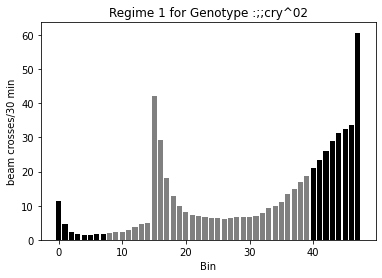

In [113]:
info,data=next(df_genotype[:1].iterrows())
plot_bars(genotype=info[0],regime=info[1],activity=data)

Let's plot the percentage of light on activity for each genotype and each regime

In [117]:
def percent_light_activity(df):
    R_1=[]
    R_2=[]
    R_3=[]
    for info,data in df.iterrows():
        if info[1]==1 or info[1]==3:
            dark=8
        else:
            dark=12

        if data.sum()>0:
            avg_light_activity=100*data[dark:48-dark].sum()/data.sum()
        else: 
            avg_light_activity=0

        if info[1]==1:
            R_1.append((info[0],avg_light_activity))
        elif info[1]==2:
            R_2.append((info[0],avg_light_activity))
        elif info[1]==3:
            R_3.append((info[0],avg_light_activity))
    
    return R_1,R_2,R_3

In [118]:
R_1,R_2,R_3=percent_light_activity(df_genotype)

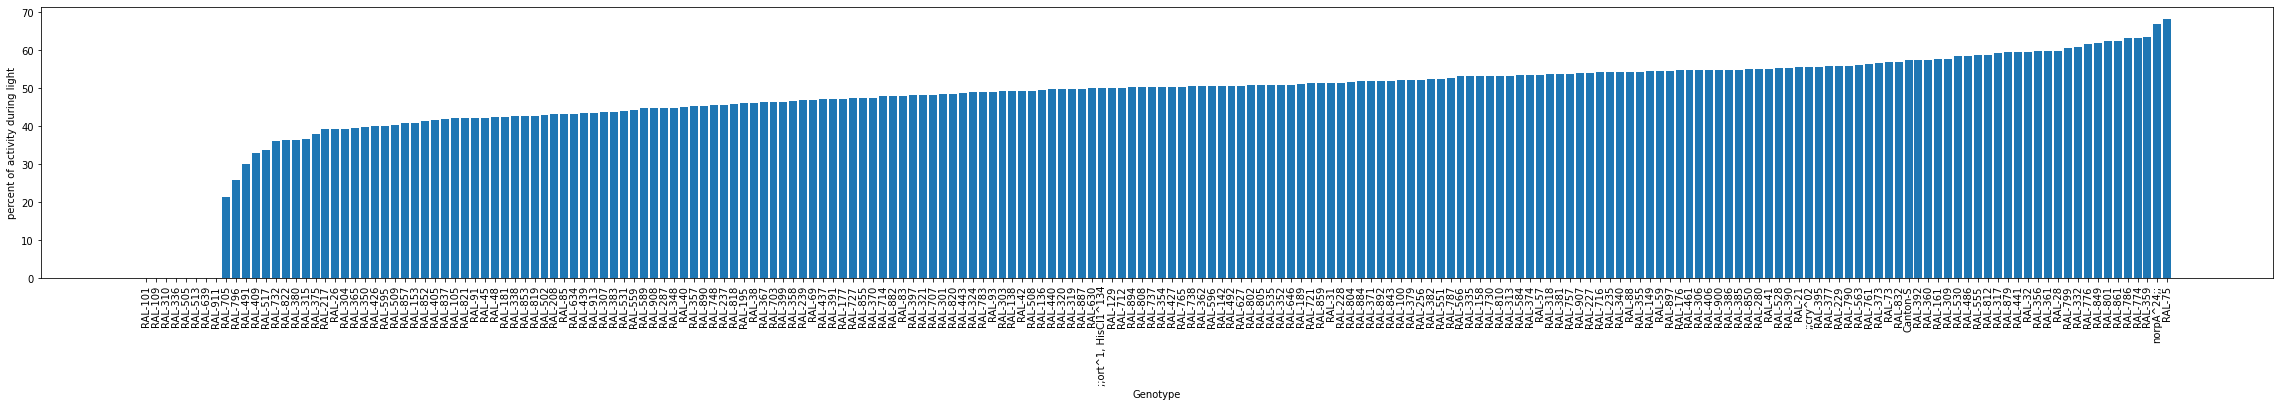

In [120]:
plt.figure(figsize=(40,5))
plt.bar(*zip(*sorted(R_2, key=lambda tup: tup[1])))
plt.xticks(rotation='vertical')
plt.xlabel('Genotype')
plt.ylabel('percent of activity during light')
plt.show()

### Create 3 df on for each regime

In [175]:
R_1=[]
R_2=[]
R_3=[]
for info,data in df_genotype.iterrows():
    data=list(data[:-1])
    data.append(info[0])
    if info[1]==1:
        R_1.append(data)
    elif info[1]==2:
        R_2.append(data)
    elif info[1]==3:
        R_3.append(data)
df_R1=pd.DataFrame(R_1,columns=df_genotype.columns)
df_R2=pd.DataFrame(R_2,columns=df_genotype.columns)
df_R3=pd.DataFrame(R_3,columns=df_genotype.columns)

In [176]:
df_R1

,avg_bin_1,avg_bin_2,avg_bin_3,avg_bin_4,avg_bin_5,avg_bin_6,avg_bin_7,avg_bin_8,avg_bin_9,avg_bin_10,...,avg_bin_40,avg_bin_41,avg_bin_42,avg_bin_43,avg_bin_44,avg_bin_45,avg_bin_46,avg_bin_47,avg_bin_48,genotype
0,11.480625,4.486875,2.390000,1.803750,1.390000,1.426875,1.719375,1.556875,2.118750,2.329375,...,18.660625,21.076250,23.388125,26.078750,29.015625,31.191250,32.556875,33.746875,60.708750,;;cry^02
1,18.586667,8.475556,4.520635,3.544762,2.851429,3.401905,3.522540,3.419683,4.084444,4.606349,...,25.406984,30.648889,34.556825,36.167619,35.237460,31.133968,25.890159,20.340952,35.067302,";;ort^1, HisCl1^134"
2,1.955625,1.443750,1.376250,1.457500,1.267500,1.549375,1.635625,2.364375,2.096875,2.503750,...,29.790625,33.841875,36.169375,38.861250,40.406250,41.191250,40.766875,39.198750,32.450625,Canton-S
3,0.287500,0.793750,0.962500,1.187500,1.056250,1.312500,0.900000,1.443750,1.475000,1.112500,...,37.331250,46.337500,55.100000,54.937500,54.287500,45.056250,35.593750,25.225000,15.293750,RAL-100
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,RAL-101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,69.434091,39.184091,26.020455,19.313636,15.188636,12.709091,12.136364,13.600000,13.434091,11.631818,...,35.315909,38.686364,42.131818,43.925000,45.597727,45.963636,45.347727,44.231818,116.554545,RAL-91
200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,RAL-911
201,53.925000,29.743750,18.362500,10.362500,7.056250,4.643750,5.618750,4.862500,2.350000,2.818750,...,20.393750,22.743750,27.143750,31.406250,32.125000,35.275000,35.531250,37.112500,83.375000,RAL-913
202,45.456250,12.087500,4.793750,2.593750,2.581250,2.781250,2.312500,1.918750,2.568750,3.137500,...,39.368750,43.081250,47.262500,48.175000,50.875000,49.187500,48.631250,46.731250,91.775000,RAL-93


### Clustering

We will first apply a PCA on the df_genotype to observe if have clusters between the bins. PCA is effected by scale so we need to scale the features in our data before applying PCA. StandardScaler will standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms.

In [135]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [228]:
def PCA_plot(df,n_components):
    df_scaled=StandardScaler().fit_transform(df)
    pca=PCA(n_components=n_components)
    pca.fit(df_scaled)
    df_pca=pca.transform(df_scaled)
    print(pca.explained_variance_ratio_)
    print(abs(pca.components_))
    plt.scatter(df_pca[:,0],df_pca[:,1],c=df[df.columns[-1]])
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

[0.63257624 0.18203172]
[[0.09922168 0.0947397  0.10214607 0.10982215 0.11464251 0.11510098
  0.11509847 0.11311684 0.11758824 0.11882597 0.12193103 0.11919398
  0.12457751 0.1256731  0.1263484  0.14357431 0.15914072 0.1619531
  0.16322576 0.16479511 0.16452056 0.16526317 0.1651778  0.16630766
  0.16349586 0.16257101 0.15995804 0.15835044 0.15676928 0.15686777
  0.15704293 0.15558389 0.15685053 0.15704266 0.15857014 0.1597166
  0.15599717 0.15275055 0.14960016 0.14777528 0.14624979 0.14691938
  0.14793812 0.14911438 0.15140822 0.15267894 0.15412414 0.12609523]
 [0.16707969 0.20053062 0.21845409 0.23419001 0.24011677 0.24218583
  0.24459285 0.24740839 0.23833779 0.2330172  0.22637696 0.22758388
  0.21199954 0.20160508 0.19388836 0.04305259 0.05444787 0.03632463
  0.02978    0.0295965  0.03159455 0.02595578 0.02798929 0.03458086
  0.03668027 0.04373114 0.04801959 0.05694361 0.0603421  0.07163485
  0.08069079 0.09840349 0.10245084 0.1136278  0.11473873 0.11848136
  0.12832138 0.13551612 0

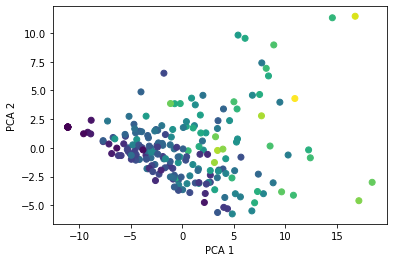

In [229]:
PCA_plot(df_R1.loc[:,df_R1.columns!='genotype'],2)

[0.60273823 0.17977057]
[[0.12014522 0.12221935 0.12761114 0.13253663 0.13188162 0.13016641
  0.13294655 0.1344476  0.13808067 0.1397163  0.14254692 0.14417296
  0.14757575 0.1477487  0.14836554 0.147404   0.14690048 0.14454718
  0.14494518 0.13665367 0.1499992  0.15911417 0.16237342 0.16426195
  0.16329709 0.16380989 0.16067769 0.15739214 0.15547058 0.15304191
  0.15108632 0.15172121 0.15216766 0.15510777 0.15431382 0.15405133
  0.15180569 0.14902522 0.14559905 0.14211858 0.14066097 0.13988221
  0.13826174 0.13196868 0.12413197 0.12402826 0.12534685 0.12248644]
 [0.15330963 0.16803014 0.18722418 0.19815816 0.20739356 0.20815542
  0.2068898  0.20122705 0.1924413  0.19247858 0.19077602 0.17828778
  0.16330639 0.14909592 0.1257296  0.10446856 0.09117483 0.08108625
  0.06813568 0.12988179 0.12787561 0.10741873 0.08648825 0.07859584
  0.07573866 0.07438925 0.08385021 0.09380798 0.10072906 0.10853814
  0.11687181 0.12172198 0.13622604 0.14133011 0.15478465 0.16330499
  0.16523812 0.16947015

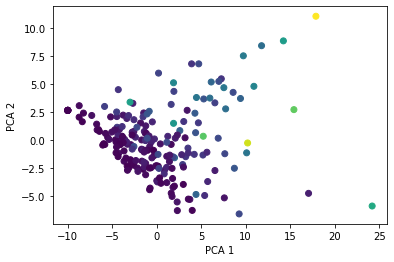

In [230]:
PCA_plot(df_R2.loc[:,df_R2.columns!='genotype'],2)

[0.65096612 0.17343473]
[[0.10998459 0.11016368 0.11246515 0.11234585 0.11475965 0.11416556
  0.11776249 0.11626857 0.11481254 0.11664554 0.12326863 0.12615528
  0.1286918  0.13503653 0.13398778 0.14258548 0.15487639 0.15886773
  0.15924242 0.15936986 0.15820868 0.15847884 0.15946801 0.15897542
  0.16109673 0.15990176 0.1591526  0.16047805 0.16105477 0.16040454
  0.16277761 0.16414926 0.16316205 0.1622149  0.15934657 0.15761199
  0.15532933 0.15389369 0.15241803 0.15047095 0.14909769 0.14760604
  0.14573621 0.14312868 0.14169909 0.14229086 0.14018517 0.12170983]
 [0.13969981 0.18342511 0.20010822 0.21616616 0.23405318 0.23588125
  0.23559978 0.23393732 0.23122724 0.2206941  0.21159291 0.20202651
  0.17816694 0.15640987 0.14231024 0.06404254 0.06887035 0.02700357
  0.00145303 0.02184822 0.03778974 0.04497721 0.0406239  0.03051902
  0.0239667  0.0164085  0.00698973 0.01039965 0.02616766 0.03469577
  0.05788942 0.07251575 0.09085262 0.1107415  0.13103918 0.13969726
  0.14637517 0.15309489

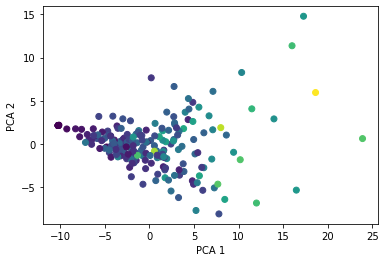

In [231]:
PCA_plot(df_R3.loc[:,df_R3.columns!='genotype'],2)